In [32]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np


In [33]:
txs = pd.read_pickle('../transactions.pkl')

In [41]:
# Simple questions to ensure our data is sane before we start building models

# 1. How many transactions are in the dataset?
print(f"Number of transactions: {len(txs)}")

# 2. What is the average wait time?
avg_waittime = txs['waittime'].mean()
print(f"Average wait time: {int(avg_waittime)} seconds")

# 3. What is the average mempool size?
avg_mempool_size = txs['mempool_size'].mean()
print(f"Average mempool size: {int(avg_mempool_size)}")

# 4. time window for txs
min_found_at = pd.to_datetime(txs['found_at'].min(), unit='s')
max_found_at = pd.to_datetime(txs['found_at'].max(), unit='s')
print(f"Time window for txs: {min_found_at} to {max_found_at}")



Number of transactions: 91119
Average wait time: 1241 seconds
Average mempool size: 17477548
Time window for txs: 2025-05-09 09:08:34 to 2025-05-09 18:15:56


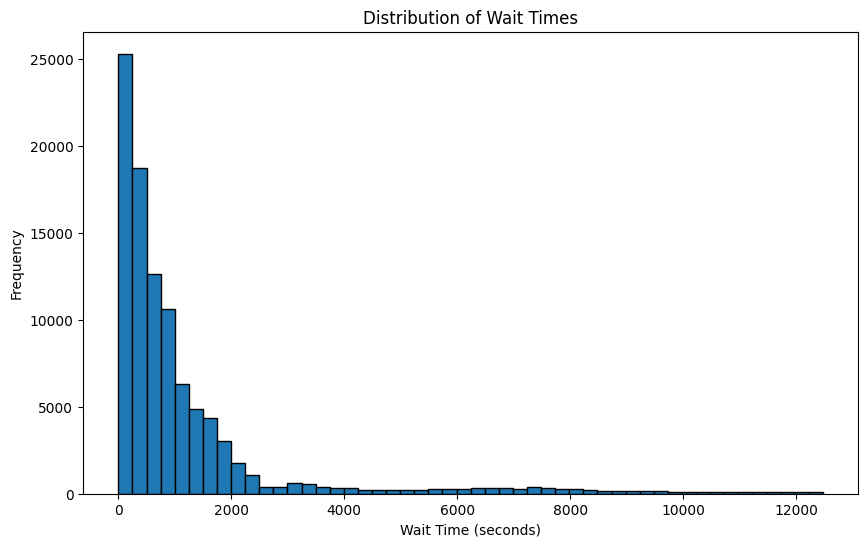

In [35]:
# Plot distribution of wait times
plt.figure(figsize=(10, 6))
plt.hist(txs['waittime'], bins=50, edgecolor='black')
plt.title('Distribution of Wait Times')
plt.xlabel('Wait Time (seconds)')
plt.ylabel('Frequency')
plt.show()

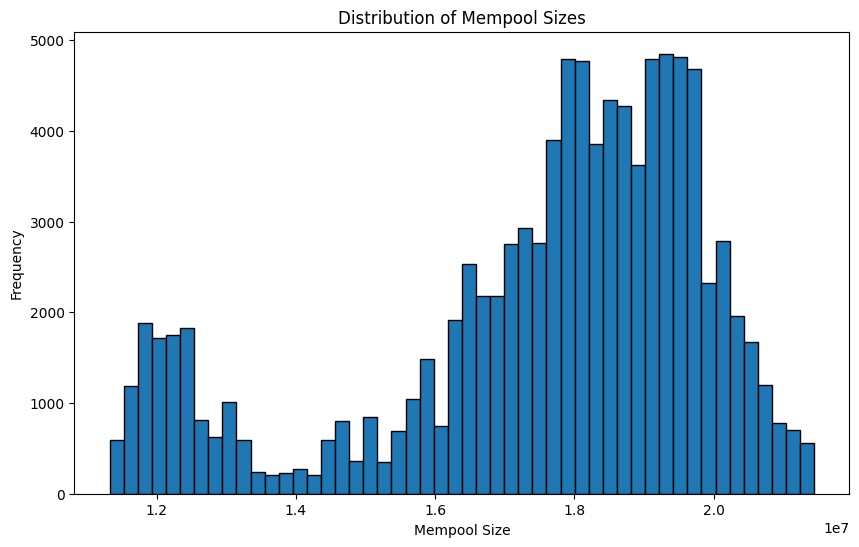

In [36]:
# Plot the distribution of mempool sizes
plt.figure(figsize=(10, 6))
plt.hist(txs['mempool_size'], bins=50, edgecolor='black')
plt.title('Distribution of Mempool Sizes')
plt.xlabel('Mempool Size')
plt.ylabel('Frequency')
plt.show()

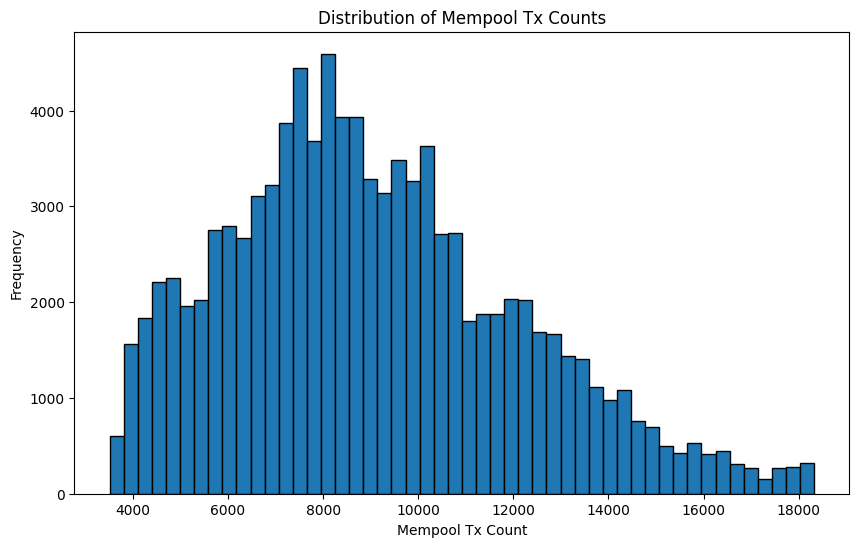

In [37]:
# Plot mempool tx count
plt.figure(figsize=(10, 6))
plt.hist(txs['mempool_tx_count'], bins=50, edgecolor='black')
plt.title('Distribution of Mempool Tx Counts')
plt.xlabel('Mempool Tx Count')
plt.ylabel('Frequency')
plt.show()


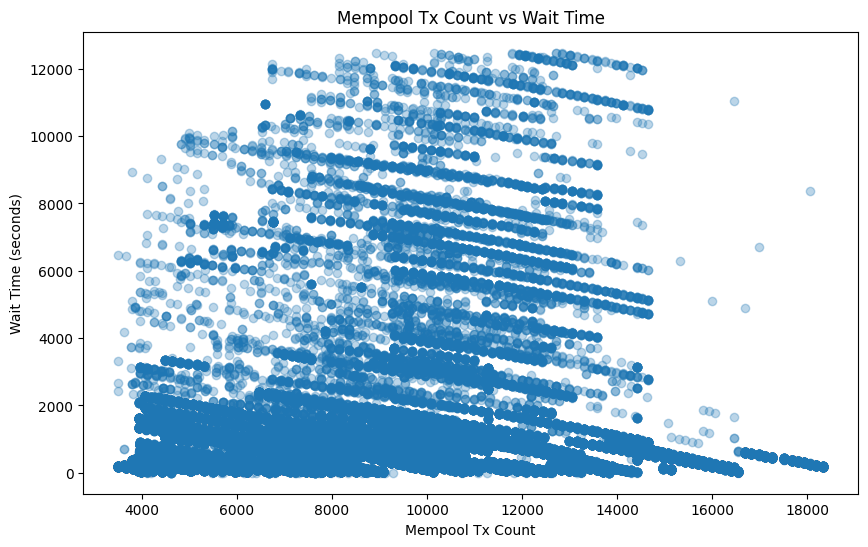

In [38]:
# Plot mempool size vs waittime
plt.figure(figsize=(10, 6))
plt.scatter(txs['mempool_tx_count'], txs['waittime'], alpha=0.3)
plt.xlabel('Mempool Tx Count')
plt.ylabel('Wait Time (seconds)')
plt.title('Mempool Tx Count vs Wait Time')
plt.show()

In [42]:
# Lets remove the weird tail of the distribution
txs = txs[txs['mempool_tx_count'] <= 14_000]

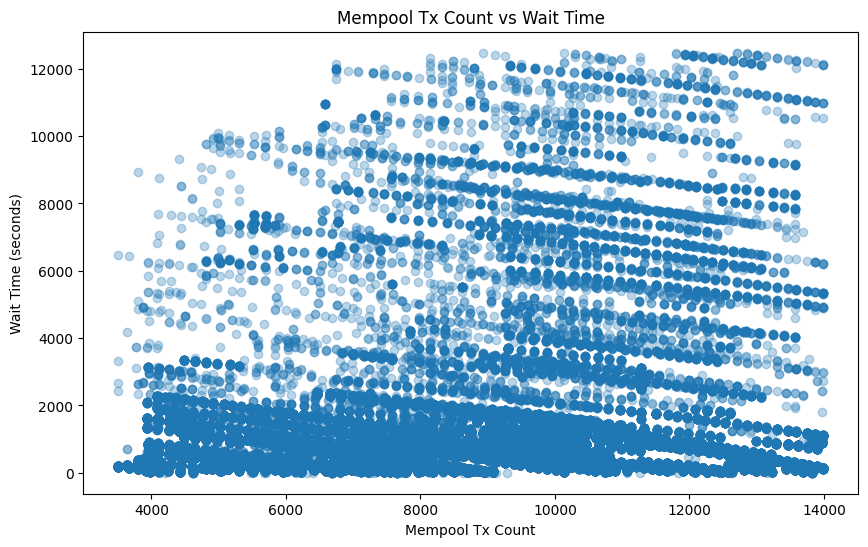

In [44]:
# Compute heat map of mempool tx count vs waittime
plt.figure(figsize=(10, 6))
plt.scatter(txs['mempool_tx_count'], txs['waittime'], alpha=0.3)
plt.xlabel('Mempool Tx Count')
plt.ylabel('Wait Time (seconds)')
plt.title('Mempool Tx Count vs Wait Time')
plt.show()

/home/hash160/dev/DCI-Bitcoin-Fee-Estimation/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


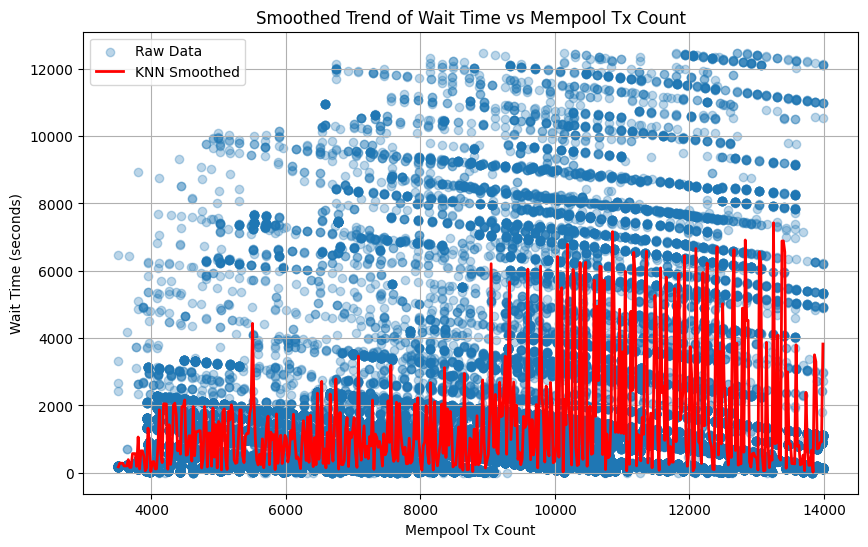

In [40]:
from sklearn.neighbors import KNeighborsRegressor

X = txs[['mempool_tx_count']]
y = txs['waittime']

# Fit KNN regressor (acts like a smoother)
knn = KNeighborsRegressor(n_neighbors=25, weights='distance')  # try tuning n_neighbors
knn.fit(X, y)

# Predict over a sorted X for a smooth curve
X_plot = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
y_smooth = knn.predict(X_plot)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.3, label="Raw Data")
plt.plot(X_plot, y_smooth, color='red', linewidth=2, label="KNN Smoothed")
plt.xlabel("Mempool Tx Count")
plt.ylabel("Wait Time (seconds)")
plt.title("Smoothed Trend of Wait Time vs Mempool Tx Count")
plt.legend()
plt.grid(True)
plt.show()



Regression results:
  Intercept: -513.4782
Beta_mempool_size: 0.0001
Train R² = 0.0175
Test R² = 0.0179


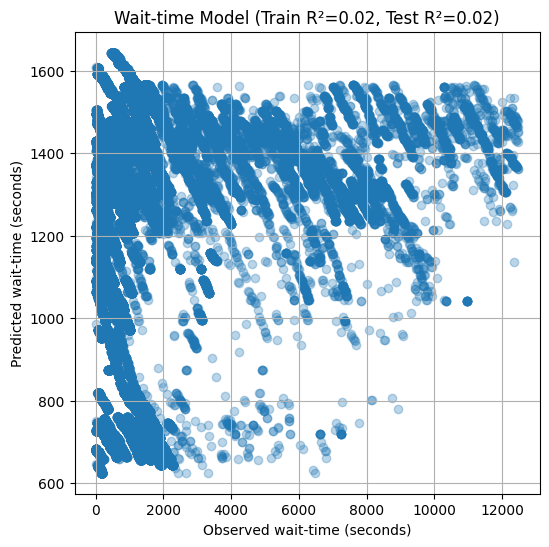

In [43]:
X = txs[['mempool_size']]
y = txs['waittime']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression().fit(X_train, y_train)
train_r2 = model.score(X_train, y_train)
test_r2 = model.score(X_test, y_test)

# print coefficients
print("\nRegression results:")
print(f"  Intercept: {model.intercept_:.4f}")
for feat, coef in zip(X.columns, model.coef_):
    print(f"Beta_{feat}: {coef:.4f}")
print(f"Train R² = {train_r2:.4f}")
print(f"Test R² = {test_r2:.4f}")

# scatter plot observed vs. predicted
yhat = model.predict(X)
plt.figure(figsize=(6,6))
plt.scatter(y, yhat, alpha=0.3)
plt.xlabel('Observed wait-time (seconds)')
plt.ylabel('Predicted wait-time (seconds)')
plt.title(f'Wait-time Model (Train R²={train_r2:.2f}, Test R²={test_r2:.2f})')
plt.grid(True)
